# Module 4 Final Project Submission

- Student Name: John Casey Dean
- Student Pace: Part Time
- Scheduled Review:
- Instructor Name: Lindsey Berlin
- Blog Post URL:



# Summary



# Introduction

# Preprocessing and EDA
## Previewing the File

As this dataset is primarily text data, we had to approach it a little differently from our previous projects that were composed primarily of numerical data. To this end, our first step was to open the 'tweets.csv' file in Excel or Sheets to try to get a feel for what kind of preprocessing steps may be required. Below is a screenshot of the first few lines of the data in Excel.

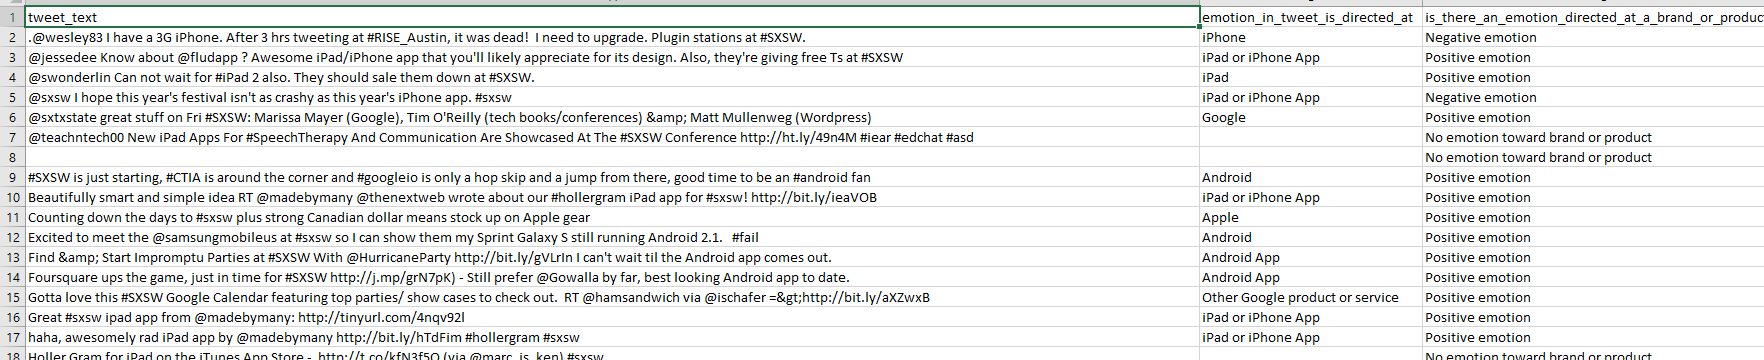

Scrolling through the file, we can see that there are several decisions we will have to answer over the course of our project.

- How do we deal with missing data?
- Is there a difference between "I can't tell" and "No emotion toward brand or product"?
- Do we want to gauge sentiment for specific brands and products or just sentiment overall?
- Do neutral tweets matter to our model, and if so do we have an imbalanced data problem?
- How do we handle mentions and hashtags?

All of these are questions that must be answered before we can begin building a model that works for us. We will begin by working through the first two problems and then setting up our data set for success in answering the remaining questions.

## Importing Libraries and Data

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk # Our NLP package
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer # A tokenizer that will strip mentions out of our tweets
from nltk.tokenize import word_tokenize # A standard tokenizer
from nltk.corpus import stopwords # A list of stopwords to remove from our tweets

import re

In [40]:
# Importing the dataset and checking that it imported properly
df = pd.read_csv('tweets.csv', encoding = 'ansi')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# Preprocessing

Before we begin, our column headings are unnecessarily verbose. For readability, lets rename our columns, then let's look at the question of missing data.

In [41]:
df.rename(columns= {'tweet_text' : 'text', 
                    'emotion_in_tweet_is_directed_at' : 'product or brand', 
                    'is_there_an_emotion_directed_at_a_brand_or_product' : 'emotion'}, 
          inplace = True)

### Missing Values

In [42]:
df.isna().sum()

text                   1
product or brand    5802
emotion                0
dtype: int64

Here we see there is a tweet with no text in it. We can safely remove that single tweet. As for the 5802 missing in 'product or brand', we will insert 'unknown'.

In [43]:
df['product or brand'].fillna(value = 'Unknown', inplace = True)

In [44]:
df.isna().sum()

text                1
product or brand    0
emotion             0
dtype: int64

In [45]:
df.dropna(axis=0, inplace=True)

In [46]:
df.isna().sum()

text                0
product or brand    0
emotion             0
dtype: int64

### "I can't tell" vs "No emotion toward brand or product"
We've filled in all of our missing values! Now we'll move on to our question about classifications!

In [47]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

Let's take samples from the observations marked "no emotion", and those marked "I can't tell" and compare to see if there is a difference.

In [48]:
no_emotion_df = df[df['emotion'] == 'No emotion toward brand or product']
cant_tell_df = df[df['emotion'] == 'I can\'t tell']

In [49]:
no_emotion_df.reset_index().head()

,index,text,product or brand,emotion
0,5,@teachntech00 New iPad Apps For #SpeechTherapy...,Unknown,No emotion toward brand or product
1,16,Holler Gram for iPad on the iTunes App Store -...,Unknown,No emotion toward brand or product
2,32,"Attn: All #SXSW frineds, @mention Register fo...",Unknown,No emotion toward brand or product
3,33,Anyone at #sxsw want to sell their old iPad?,Unknown,No emotion toward brand or product
4,34,Anyone at #SXSW who bought the new iPad want ...,Unknown,No emotion toward brand or product


In [50]:
cant_tell_df.reset_index().head()

,index,text,product or brand,emotion
0,90,Thanks to @mention for publishing the news of ...,Unknown,I can't tell
1,102,‰ÛÏ@mention &quot;Apple has opened a pop-up st...,Unknown,I can't tell
2,237,Just what America needs. RT @mention Google to...,Unknown,I can't tell
3,341,The queue at the Apple Store in Austin is FOUR...,Unknown,I can't tell
4,368,Hope it's better than wave RT @mention Buzz is...,Unknown,I can't tell


As we can see, both categories seem to include tweets that are either purely informational, or are too vague to judge emotion from. For simplicity we will rename both categories to 'No emotion'.

In [51]:
# Function for renaming our emotion column
def rename_emotion(x):
    if (x == 'No emotion toward brand or product') | (x == 'I can\'t tell') :
        x = 'No emotion'
    return x

In [52]:
df['emotion'] = df.emotion.apply(rename_emotion)

In [53]:
df.emotion.value_counts()

No emotion          5544
Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

This looks much better and certainly less verbose. Now we just have to tokenize our data and clean that up a bit before moving on to actually building our model.

In [54]:
def strip_data(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    
    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    
    #Removing special characters
    data = re.sub(r'[*!+&?^%$#.\/:,]', r'', data)
    
    return data

In [55]:
#stripping special characters and converting all words to lower case
df['text'] = df['text'].apply(strip_data).str.lower()
df['text'].head()

0    @wesley83 i have a 3g iphone after 3 hrs tweet...
1    @jessedee know about @fludapp  awesome ipadiph...
2    @swonderlin can not wait for ipad 2 also they ...
3    @sxsw i hope this years festival isnt as crash...
4    @sxtxstate great stuff on fri sxsw marissa may...
Name: text, dtype: object

In [56]:
#tokenizing text, including removing mentions
tknzr = TweetTokenizer(strip_handles=True)
df['text'] = df['text'].apply(tknzr.tokenize)

In [57]:
df['text'][0]

['i',
 'have',
 'a',
 '3g',
 'iphone',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 'rise_austin',
 'it',
 'was',
 'dead',
 'i',
 'need',
 'to',
 'upgrade',
 'plugin',
 'stations',
 'at',
 'sxsw']

In [59]:
#import nltk stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [61]:
stopwords = [word.lower() for word in stopwords]

In [63]:
def remove_stopwords(words, stopwords):
    words = [word.lower() for word in words if word.lower() not in stopwords]
    return words

In [66]:
df['text'] = df.text.apply(remove_stopwords, args=(stopwords,))
df['text'][0]

['3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In [68]:
stemmer = SnowballStemmer('english')

In [70]:
def stem_words(words, stemmer):
    words = [stemmer.stem(word) for word in words]
    return words

In [71]:
df['text'] = df.text.apply(stem_words, args=(stemmer,))
df['text'][0]

['3g',
 'iphon',
 '3',
 'hrs',
 'tweet',
 'rise_austin',
 'dead',
 'need',
 'upgrad',
 'plugin',
 'station',
 'sxsw']